<a href="https://colab.research.google.com/github/imnbid/SystemIdentification/blob/main/HW1_Implementations/Q1Impliment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# ----- پارامترها -----
N = 1200
sigma2 = 0.12   # واریانس نویز
np.random.seed(0)  # برای تکرارپذیری

# ----- تولید داده -----
u = np.random.uniform(-1, 1, N)
e = np.random.normal(0, np.sqrt(sigma2), N)

# سیستم اصلی
y_clean = 0.90 + 1.80*u - 1.10*u**2 + 0.35*u**4 - 0.22*u**6 + 0.08*u**8
y = y_clean + e

# ----- تقسیم آموزش و تست (70/30) -----
split = int(0.7 * N)
u_train, u_test = u[:split], u[split:]
y_train, y_test = y[:split], y[split:]
y_clean_train, y_clean_test = y_clean[:split], y_clean[split:]

In [ ]:
def design_matrix(u, degree):
    return np.column_stack([u**i for i in range(degree+1)])

# مثال: درجه 8 چون سیستم تا توان 8 دارد
deg_full = 8
X_train = design_matrix(u_train, deg_full)
X_test = design_matrix(u_test, deg_full)

In [ ]:
theta_hat, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)

print("θ تخمین زده شده:")
for i, val in enumerate(theta_hat):
    print(f"u^{i}: {val:.5f}")

# پیش‌بینی روی داده تست
y_pred_test = X_test @ theta_hat
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE تست: {rmse_test:.5f}")

θ تخمین زده شده:
u^0: 0.92449
u^1: 1.87201
u^2: -0.79753
u^3: -0.55140
u^4: -2.48126
u^5: 1.05095
u^6: 5.51651
u^7: -0.54214
u^8: -3.18684
RMSE تست: 0.34008


best order of polynomials 3


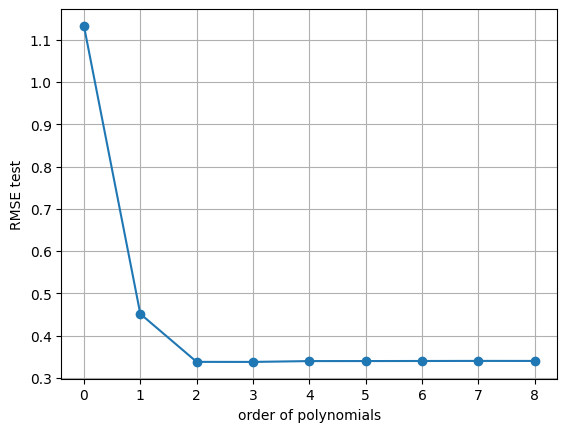

In [ ]:
rmse_list = []
degrees = range(0, 9)  # از درجه 0 تا 8

for d in degrees:
    Xtr = design_matrix(u_train, d)
    Xte = design_matrix(u_test, d)
    coef, _, _, _ = np.linalg.lstsq(Xtr, y_train, rcond=None)
    y_pred = Xte @ coef
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

best_deg = degrees[np.argmin(rmse_list)]
print("best order of polynomials", best_deg)

plt.plot(degrees, rmse_list, marker='o')
plt.xlabel('order of polynomials')
plt.ylabel("RMSE test")
plt.grid(True)
plt.show()

In [ ]:
X_clean_train = design_matrix(u_train, deg_full)
X_clean_test = design_matrix(u_test, deg_full)

In [ ]:
def forward_selection(X, y):
    selected = []
    remaining = list(range(X.shape[1]))  # اندیس ستون‌ها
    best_score = float('inf')

    while remaining:
        scores = []
        for candidate in remaining:
            cols = selected + [candidate]
            coef, _, _, _ = np.linalg.lstsq(X[:, cols], y, rcond=None)
            y_pred = X[:, cols] @ coef
            scores.append((candidate, mean_squared_error(y, y_pred)))
        scores.sort(key=lambda x: x[1])
        best_candidate, best_mse = scores[0]
        if best_mse < best_score:
            best_score = best_mse
            selected.append(best_candidate)
            remaining.remove(best_candidate)
        else:
            break
    return selected

fs_selected = forward_selection(X_clean_train, y_clean_train)
print("ویژگی‌های انتخاب شده با Forward Selection:", fs_selected)

ویژگی‌های انتخاب شده با Forward Selection: [1, 0, 2, 4, 6, 8, 7]


In [ ]:
def backward_elimination(X, y):
    selected = list(range(X.shape[1]))
    best_score = mean_squared_error(y, X @ np.linalg.lstsq(X, y, rcond=None)[0])

    while len(selected) > 1:
        scores = []
        for candidate in selected:
            cols = [c for c in selected if c != candidate]
            coef, _, _, _ = np.linalg.lstsq(X[:, cols], y, rcond=None)
            y_pred = X[:, cols] @ coef
            scores.append((candidate, mean_squared_error(y, y_pred)))
        scores.sort(key=lambda x: x[1])
        worst_candidate, worst_mse = scores[0]
        if worst_mse <= best_score:
            best_score = worst_mse
            selected.remove(worst_candidate)
        else:
            break
    return selected

be_selected = backward_elimination(X_clean_train, y_clean_train)
print("ویژگی‌های انتخاب شده با Backward Elimination:", be_selected)

ویژگی‌های انتخاب شده با Backward Elimination: [0, 1, 2, 3, 4, 6, 7, 8]


In [ ]:
for var in [0.12, 0.40, 1.0]:
    e2 = np.random.normal(0, np.sqrt(var), N)
    y2 = y_clean + e2
    y2_train, y2_test = y2[:split], y2[split:]
    Xtr = design_matrix(u_train, deg_full)
    Xte = design_matrix(u_test, deg_full)
    coef, _, _, _ = np.linalg.lstsq(Xtr, y2_train, rcond=None)
    rmse = np.sqrt(mean_squared_error(y2_test, Xte @ coef))
    print(f"واریانس نویز={var:.2f} → RMSE تست={rmse:.4f}")

واریانس نویز=0.12 → RMSE تست=0.3551
واریانس نویز=0.40 → RMSE تست=0.6260
واریانس نویز=1.00 → RMSE تست=0.9752


In [ ]:
# فرض: واریانس نویز متناسب با u^2 است
sigma_var = 0.12 + 0.3*u_train**2
W = np.diag(1 / sigma_var)

theta_wls = np.linalg.inv(X_train.T @ W @ X_train) @ (X_train.T @ W @ y_train)